In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

# Задаем начальные парметры 

In [2]:
mu_1 = 0.026
mu_2 = 0.154
sigma_1 = 0.381
sigma_2 = 0.273
rho = 0.285
S0_1 = 100
S0_2 = 80
N = 1_000

In [3]:
def simulate_two_path_GBM(mu_1, mu_2, sigma_1, sigma_2, rho, S0_1, S0_2, N):
    dt = 1/252
    X = np.random.normal(0., 1., (2, N))
    C = np.array([[1, rho], [rho, 1]])
    L = np.linalg.cholesky(C)
    paths = np.dot(L, X)
    dW_1 = paths[0]
    dW_2 = paths[1]
    
    dW_1 -= np.mean(dW_1)
    dW_2 -= np.mean(dW_2)
    
    res = {"spot_1": np.zeros(N + 1), "spot_2": np.zeros(N + 1)}
    res["spot_1"][0] = S0_1
    res["spot_2"][0] = S0_2
    
    for i in range(N):
        res["spot_1"][i+1] = res["spot_1"][i] * (1. + mu_1 * dt + sigma_1 * dW_1[i] * np.sqrt(dt))
        res["spot_2"][i+1] = res["spot_2"][i] * (1. + mu_2 * dt + sigma_2 * dW_2[i] * np.sqrt(dt))
    return res

In [4]:
res = simulate_two_path_GBM(mu_1, mu_2, sigma_1, sigma_2, rho, S0_1, S0_2, N)
spot_1 = res["spot_1"]
spot_2 = res["spot_2"]

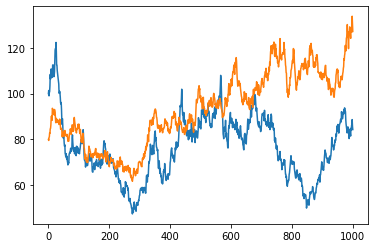

In [5]:
plt.plot(spot_1)
plt.plot(spot_2)
plt.show()

In [6]:
rets_1 = spot_1[1:] / spot_1[:-1] - 1.
rets_2 = spot_2[1:] / spot_2[:-1] - 1.

# Фактические параметры, которые получились при генерации 

In [7]:
print(f"mu_1: {(np.mean(rets_1)/(1/252)):.3f}\t mu_2: {(np.mean(rets_2)/(1/252)):.3f} ")
print(f"sigma_1: {(np.std(rets_1)/np.sqrt(1/252)):.3f}\t sigma_2: {(np.std(rets_2)/np.sqrt(1/252)):.3f} ")
print(f"rho: {(np.corrcoef(np.array([rets_1, rets_2]))[0,1]):.3f} ")
real_parameters = {"mu_1": (np.mean(rets_1)/(1/252)), "mu_2": (np.mean(rets_2)/(1/252)),\
                  "sigma_1": (np.std(rets_1)/np.sqrt(1/252)), "sigma_2": (np.std(rets_2)/np.sqrt(1/252)),\
                  "rho": (np.corrcoef(np.array([rets_1, rets_2]))[0,1])}

mu_1: 0.026	 mu_2: 0.154 
sigma_1: 0.372	 sigma_2: 0.273 
rho: 0.312 


In [8]:
rets = np.dstack((rets_1, rets_2))

In [9]:
def log_likelihood(mu_1, mu_2, sigma_1, sigma_2, rho, rets):
    dt = 1/252
    mu_1 = mu_1*dt
    mu_2 = mu_2*dt
    sigma_1 = sigma_1 * np.sqrt(dt)
    sigma_2 = sigma_2 * np.sqrt(dt)
    
    mean = np.array([mu_1, mu_2])
    cov = np.array([[sigma_1**2, rho*sigma_1*sigma_2], [rho*sigma_1*sigma_2, sigma_2**2]])
    
    rv = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    log_likelihood = np.sum(np.log(rv.pdf(rets)))
    return log_likelihood

# На след ячейку не обращаем внимания

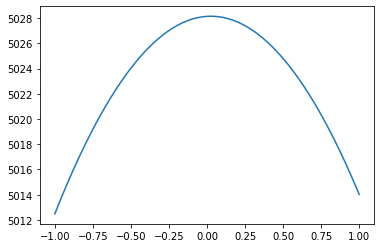

0.025025025025025016

In [10]:
x = []
y = []
for i in np.linspace(-1,1,1000):
    x.append(i)
    y.append(log_likelihood(mu_1 = i, mu_2 = mu_2, sigma_1 = sigma_1, sigma_2 = sigma_2,rho = rho, rets = rets))
    
plt.plot(x,y)
plt.show()
d = dict(zip(y,x))
d[max(y)]

In [11]:
def log_pi_mu_func(params, number, mu_0 = 1, sigma_0 = 25):
    if number == 1:
        mu = params["mu_1"]
    elif number == 2:
        mu = params["mu_2"]
    else:
        print("Error")
    prior_mu_pdf = scipy.stats.norm(mu_0, sigma_0).pdf(mu)
    log_likelihood_val = log_likelihood(**params)
    return np.log(prior_mu_pdf) + log_likelihood_val

In [12]:
def log_pi_sigma_func(params, number, alpha = 2.5, beta = 0.1):
    if number == 1:
        sigma = params["sigma_1"]
    elif number == 2:
        sigma = params["sigma_2"]
    prior_sigma_pdf = scipy.stats.invgamma(alpha, beta).pdf(sigma)
    log_likelihood_val = log_likelihood(**params)
    return np.log(prior_sigma_pdf) + log_likelihood_val

In [13]:
def log_pi_rho_func(params):
    rho = params["rho"]
    prior_rho_pdf = scipy.stats.uniform(loc = -1, scale = 2).pdf(rho)
    log_likelihood_val = log_likelihood(**params)
    return np.log(prior_rho_pdf) + log_likelihood_val

# Алгоритм выводит средние значения параметров на последних 10к реализаций выборки и в конце выводит средние значения на последних 50к

In [14]:
def metropolis_algorithm(steps, params):
    res = {"mu_1": [], "mu_2": [], "sigma_1": [], "sigma_2": [], "rho": []}
    for i in range(steps):
        if (i+1)%10_000 == 0:
            print(f"Iteration: {i+1}/{steps}")
            print(f"mean(mu_1): {np.mean(res['mu_1'][-10_000:])}\t std(mu_1): {np.std(res['mu_1'][-10_000:])}")
            print(f"mean(mu_2): {np.mean(res['mu_2'][-10_000:])}\t std(mu_2): {np.std(res['mu_2'][-10_000:])}")
            print(f"mean(sigma_1): {np.mean(res['sigma_1'][-10_000:])}\t std(sigma_1): {np.std(res['sigma_1'][-10_000:])}")
            print(f"mean(sigma_2): {np.mean(res['sigma_2'][-10_000:])}\t std(sigma_2): {np.std(res['sigma_2'][-10_000:])}")
            print(f"mean(rho): {np.mean(res['rho'][-10_000:])}\t std(rho): {np.std(res['rho'][-10_000:])}")
            print("-----------------------------------------------------")
            print("\n")
            
        
        mu_1_new = params["mu_1"] + np.random.normal(0, 1)
        mu_2_new = params["mu_2"] + np.random.normal(0, 1)
        sigma_1_new = params["sigma_1"] + np.random.normal(0, 1)
        sigma_2_new = params["sigma_2"] + np.random.normal(0, 1)
        rho_new = params["rho"] + np.random.normal(0, 1)
        while np.abs(rho_new) > 1:
            rho_new = params["rho"] + np.random.normal(0,1)
        
        new_params = params.copy()
        new_params["mu_1"] = mu_1_new
        log_ratio_mu_1 = log_pi_mu_func(new_params, 1) - log_pi_mu_func(params, 1)
        ratio_mu_1 = np.exp(log_ratio_mu_1)
        alpha_mu_1 = min(1, ratio_mu_1)
        u = np.random.uniform(0, 1)
        if alpha_mu_1 > u:
            params["mu_1"] = mu_1_new
        res["mu_1"].append(params["mu_1"])
        
        new_params = params.copy()
        new_params["mu_2"] = mu_2_new
        log_ratio_mu_2 = log_pi_mu_func(new_params, 2) - log_pi_mu_func(params, 2)
        ratio_mu_2 = np.exp(log_ratio_mu_2)
        alpha_mu_2 = min(1, ratio_mu_2)
        u = np.random.uniform(0, 1)
        if alpha_mu_2 > u:
            params["mu_2"] = mu_2_new
        res["mu_2"].append(params["mu_2"])
        
        
        new_params = params.copy()
        new_params["sigma_1"] = sigma_1_new
        log_ratio_sigma_1 = log_pi_sigma_func(new_params, 1) - log_pi_sigma_func(params, 1)
        ratio_sigma_1 = np.exp(log_ratio_sigma_1)
        alpha_sigma_1 = min(1, ratio_sigma_1)
        u = np.random.uniform(0, 1)
        if alpha_sigma_1 > u:
            params["sigma_1"] = sigma_1_new
        res["sigma_1"].append(params["sigma_1"])
        
        
        new_params = params.copy()
        new_params["sigma_2"] = sigma_2_new
        log_ratio_sigma_2 = log_pi_sigma_func(new_params, 2) - log_pi_sigma_func(params, 2)
        ratio_sigma_2 = np.exp(log_ratio_sigma_2)
        alpha_sigma_2 = min(1, ratio_sigma_2)
        u = np.random.uniform(0, 1)
        if alpha_sigma_2 > u:
            params["sigma_2"] = sigma_2_new
        res["sigma_2"].append(params["sigma_2"])
        
        
        new_params = params.copy()
        new_params["rho"] = rho_new
        log_ratio_rho = log_pi_rho_func(new_params) - log_pi_rho_func(params)
        ratio_rho = np.exp(log_ratio_rho)
        alpha_rho = min(1, ratio_rho)
        u = np.random.uniform(0, 1)
        if alpha_rho > u:
            params["rho"] = rho_new
        res["rho"].append(params["rho"])
        
        
        
    print("FINAL")
    print(f"mean(mu_1): {np.mean(res['mu_1'][-50_000:])}\t std(mu_1): {np.std(res['mu_1'][-50_000:])}")
    print(f"mean(mu_2): {np.mean(res['mu_2'][-50_000:])}\t std(mu_2): {np.std(res['mu_2'][-50_000:])}")
    print(f"mean(sigma_1): {np.mean(res['sigma_1'][-50_000:])}\t std(sigma_1): {np.std(res['sigma_1'][-50_000:])}")
    print(f"mean(sigma_2): {np.mean(res['sigma_2'][-50_000:])}\t std(sigma_2): {np.std(res['sigma_2'][-50_000:])}")
    print(f"mean(rho): {np.mean(res['rho'][-50_000:])}\t std(rho): {np.std(res['rho'][-50_000:])}")

    return res

In [15]:
inital_params = {"mu_1": 1, "mu_2": 1, "sigma_1": 1, "sigma_2": 1, "rho": 0.9, "rets": rets}

In [16]:
res = metropolis_algorithm(100_000, inital_params)

C:\Users\User\AppData\Local\Temp\ipykernel_14892\2220182193.py:8: RuntimeWarning: divide by zero encountered in log
  return np.log(prior_sigma_pdf) + log_likelihood_val
C:\Users\User\AppData\Local\Temp\ipykernel_14892\909613301.py:12: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(rv.pdf(rets)))


Iteration: 10000/100000
mean(mu_1): 0.02398446195662465	 std(mu_1): 0.18735398282534219
mean(mu_2): 0.158323900228857	 std(mu_2): 0.1438683608725344
mean(sigma_1): 0.37257662248213386	 std(sigma_1): 0.01500516716577207
mean(sigma_2): 0.2765792982191584	 std(sigma_2): 0.01797648378855463
mean(rho): 0.3124292564127626	 std(rho): 0.03461573448098462
-----------------------------------------------------


Iteration: 20000/100000
mean(mu_1): 0.021255894979278524	 std(mu_1): 0.18490971740019344
mean(mu_2): 0.14923673835612689	 std(mu_2): 0.13660792944587138
mean(sigma_1): 0.3732704091904725	 std(sigma_1): 0.007162241655490249
mean(sigma_2): 0.27420896447803544	 std(sigma_2): 0.007499462302185536
mean(rho): 0.30974162162564955	 std(rho): 0.026173148058436232
-----------------------------------------------------


Iteration: 30000/100000
mean(mu_1): 0.023431508848457277	 std(mu_1): 0.18902932788573426
mean(mu_2): 0.15811275541875616	 std(mu_2): 0.13644541506759655
mean(sigma_1): 0.373017162846

In [17]:
posterior_sigma_1 = res["sigma_1"][50_000:]
posterior_sigma_2 = res["sigma_2"][50_000:]
posterior_mu_1 = res["mu_1"][50_000:]
posterior_mu_2 = res["mu_2"][50_000:]
posterior_rho = res["rho"][50_000:]

In [18]:
import warnings
warnings.filterwarnings("ignore")

# Посмотрим на апостериорные распределения параметров

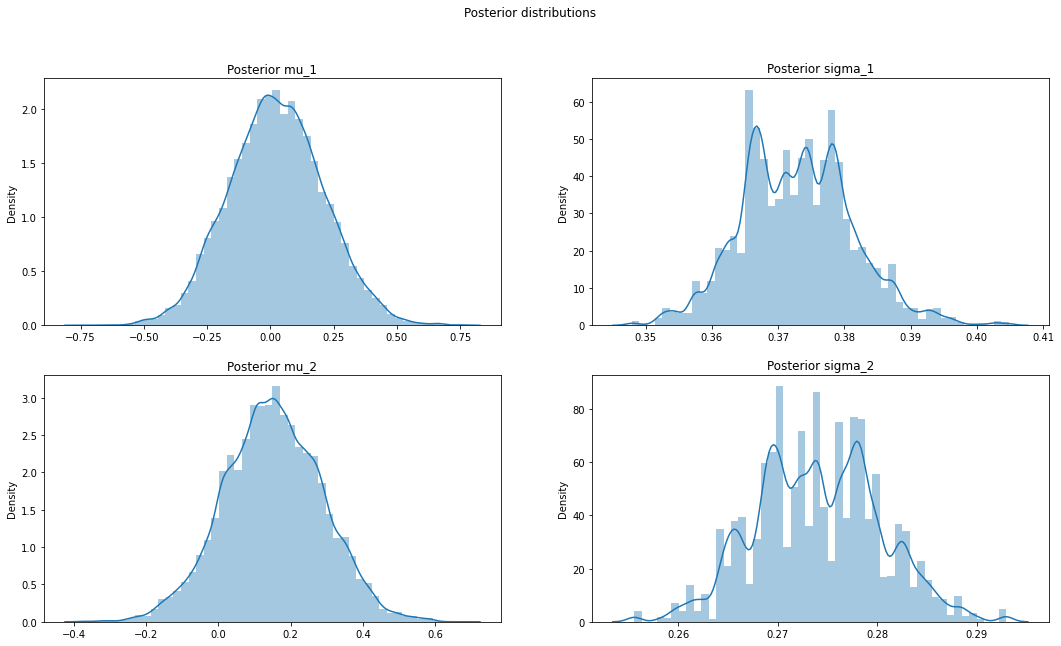

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Posterior distributions')
axes[0,0].title.set_text('Posterior mu_1')
axes[1,0].title.set_text('Posterior mu_2')
axes[0,1].title.set_text('Posterior sigma_1')
axes[1,1].title.set_text('Posterior sigma_2')

sns.distplot(posterior_mu_1, ax=axes[0, 0])
sns.distplot(posterior_mu_2, ax=axes[1, 0])
sns.distplot(posterior_sigma_1, ax=axes[0, 1])
sns.distplot(posterior_sigma_2, ax=axes[1, 1])
plt.show()

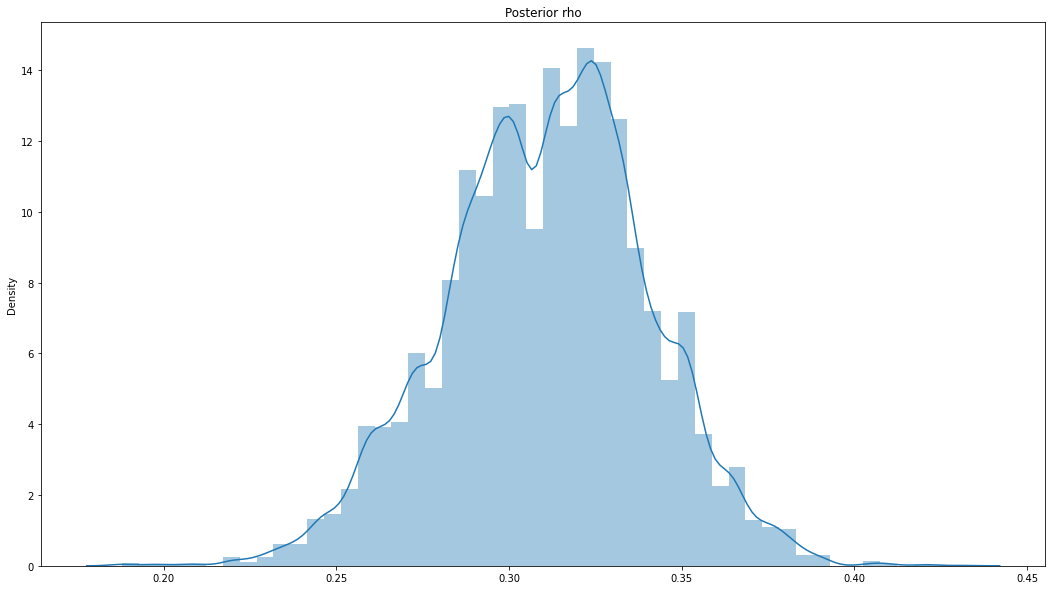

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(18, 10))
axes.title.set_text('Posterior rho')
sns.distplot(posterior_rho, ax=axes)
plt.show()

In [22]:
!pip install pandoc --user